## Import packages

In [1]:
import CairoMakie: activate!, Figure, Axis, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, contourf!, Colorbar, hist, hist!, contour!, heatmap!, text!, density!, colgap!

import StatsBase: sample, mean, min, mode, max
import NaNStatistics: nanmean, nanstd, nanmaximum, nanminimum, nanmax, nanmedian
import Distributed: addprocs, pmap, @everywhere
import Dates: now, Millisecond
import DataFrames: DataFrame
import Roots: find_zero, fzero, newton, Newton

import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
colblue=palette(:default)[1];
activate!() #activates the Makie backend
set_theme!(Theme(
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default),  
    ))

## We run parallel processes to speed up the computation

In [2]:
numprocs = 8;
addprocs(numprocs);

In [3]:
@everywhere begin
    import NaNStatistics: nanmean, nanstd, nanmaximum, nanminimum, nanmax, nanmedian
    import StatsBase: sample, mean, min, mode, max, std
    nanlength(x::AbstractArray) = sum(.~isnan.(x));
    nanse(x::AbstractArray) = nanstd(x) / sqrt(nanlength(x));

    function DecisionTrajectory(T::Number, η::Number, ϵk::AbstractVector, L::Number, numSpins::Int, IC::String,
        x_init::Number, r0::Number, timemax::Number, dLcrossed::Number)
        # T - temperature
        # η - inhibition
        # ϵk - array of biases per target
        # L - threshold
        # numSpins - number of spins in one group (per target)
        # IC - initial condition of the active spins
        # x0 - initial position
        # r0 - units of rate
        # timemax - maximum time of the simulation
        # dLcrossed - distance to cut if finish far away from the target

        ## Initialization
        k = length(ϵk); # number of targets
        Pk = [1; -1]; #directions to the targets
        Vfunc(Nk::AbstractVector) = k==2 ? sum(Nk .* Pk)/(numSpins*k) : error("k is not 2!"); # velocity of the system

        Nk_cur = IC=="ZERO" ? zeros(Int8, k) : (IC=="RAND" ? [rand(1:numSpins) for i = 1:k] : error("IC is not valid!")); #[N1, N2, N3] - VEC kx1 define the current distribution of active spins (ON)
        x = x_init; # current position of the system
        v = Vfunc(Nk_cur); # current velocity of the system
        t = 0.0; # current time of the system
        dtrand = 0.0;
        v_next = v;
        x_prev = x;
        t_prev = t;

        #v_seq = Array{Float64, 1}(); # velocities of the system
        #push!(v_seq, v); # save the initial velocity of the system
        ## Simulation
        while (abs(x) ≤ L) && (t ≤ timemax)

            v = v_next;
            x_prev = x;
            t_prev = t;

            # on/off rates
            dH = (k .* v .* Pk .- η .+ ϵk);
            rk_on    = r0* (numSpins .- Nk_cur) ./ (1 .+ exp.( -dH/T )); # group 1...k: ++1
            rk_off   = r0* Nk_cur               ./ (1 .+ exp.(  dH/T )); # group 1...k: --1
            rates    = [rk_on; rk_off]; #array of rates for each target
            rate_tot = sum(rates); # total rate

            # choose a group to change and time interval
            rand_flip = 1 - rand(); # get a second random number

            # calculate next step: one spin flip occurs
            event = findfirst(rand_flip .<= cumsum(rates ./ rate_tot)); # find the event
            off_event = Int8(event > k); # determine the sign of the event: on=(ind<=k) or off=(ind>k)
            ind_event = event - k*off_event; # index of the event
            Nk_cur[ind_event] = Nk_cur[ind_event] + (-1)^off_event;

            # calculate the time interval
            rand_time = 1 - rand(); # get a random number for gillespie
            dtrand = (1/rate_tot) * log(1/rand_time); # calculate next time interval dt

            #update velocity and position according to the new spin distributions
            x += v * dtrand; # update the position of the system using previous velocity
            v_next = Vfunc(Nk_cur); # update the velocity of the system
            t += dtrand; # update the current time
            #push!(v_seq, v); # save the initial velocity of the system
        end

        #check if the motion finished too far from the threshold L
        if abs(x) - L > L*dLcrossed 
            if sign(x) > 0
                x = L;
                dx = L - x_prev; #> 0
            else
                x = -L;
                dx = -L - x_prev; #<0
            end
            t += -dtrand + dx / v;
        end

        return sign(x), t

    end
    DecisionTrajectory(T, η, ϵk, L, numSpins; IC="ZERO", x_init=0.0, r0=1.0, timemax=1e15, dLcrossed=1e-5) = 
    DecisionTrajectory(T, η, ϵk, L, numSpins, IC, x_init, r0, timemax, dLcrossed)

    function get_error_RT_RTcRTw(η, T, ϵ1, L, numSpins, IC, iterations, dLcrossed)
        ϵk = [ϵ1, 0]; #biases
        choices = fill(NaN, iterations);
        RTs     = fill(NaN, iterations);
        #generate multiple trajectories and save choices and RTs
        for iter in 1:iterations
            choice, rt = DecisionTrajectory(T, η, ϵk, L, numSpins, IC=IC, dLcrossed=dLcrossed);
            choices[iter] = choice == 1 ? 1 : 0;
            RTs[iter] = rt;
        end
        RTsc = RTs[choices .== 1]; RTsw = RTs[choices .== 0];
        error = 1 - mean(choices);
        RT  = mean(RTs);
        RTc = mean(RTsc);
        RTw = mean(RTsw);
        RT_std  = std(RTs);
        RTc_std = std(RTsc);
        RTw_std = std(RTsw);
        RT_se  = RT_std  / sqrt(length(RTs));
        RTc_se = RTc_std / sqrt(length(RTsc));
        RTw_se = RTw_std / sqrt(length(RTsw));
        return error, RT, RTc/RTw, RT_std, (RTc_std*RTw + RTc*RTw_std)/(RTw^2), RTs
    end
end

## Run simulation

In [4]:
@everywhere begin
    Tfixed = 0.3; #temperature
    ϵ1 = 0.01; 

    L = 40; 
    numSpins = 20; #number of spins per group
    dLcrossed = 1e-4; #distance to cut if finish far away from the target
    IC_sim = "ZERO";
end

In [5]:
@everywhere iterations = 10^3;  ## simulations take about 40-50 s for 10^3 iterations
η_sim   = 0:0.05:0.6;
println(length(η_sim))

@everywhere f(x) = get_error_RT_RTcRTw(x, Tfixed, ϵ1, L, numSpins, IC_sim, iterations, dLcrossed) 

t1 = now();
raw_data_sim = pmap(f, η_sim);
t2 = now();
time_sec = (t2-t1)/Millisecond(1)*1e-3;
println("$(time_sec) s, $(round(time_sec/60, digits=2)) min, $(round(time_sec/60/60, digits=2)) h")

    err_sim = [el[1] for el in raw_data_sim];
     rt_sim = [el[2] for el in raw_data_sim];
   rtcw_sim = [el[3] for el in raw_data_sim];
  rtstd_sim = [el[4] for el in raw_data_sim];
rtcwstd_sim = [el[5] for el in raw_data_sim];
    rts_sim = [el[6] for el in raw_data_sim];

13
49.413000000000004 s, 0.82 min, 0.01 h


## Plot Error, RT, and RTc/RTw

In [6]:
Fblue(T) = T*acosh((1-T)/T); # blue transition line

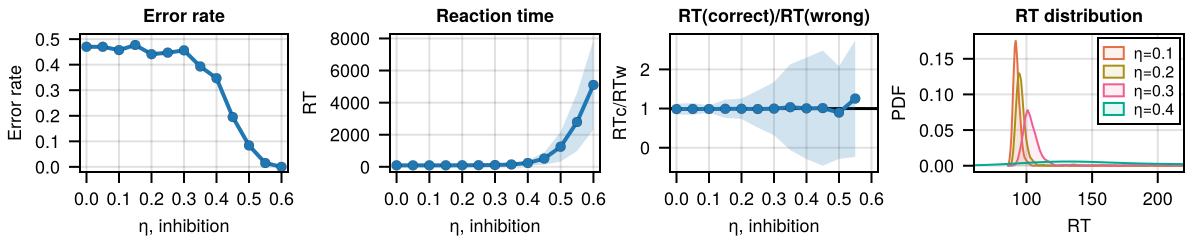

In [8]:
fig = Figure(size=(600, 120), fontsize=9, figure_padding=(3, 8, 3, 3));  ax = [];  #400, 300  
    push!(ax, Axis(fig[1, 1], xlabel="η, inhibition", ylabel="Error rate", title="Error rate"));
    push!(ax, Axis(fig[1, 2], xlabel="η, inhibition", ylabel="RT",  title="Reaction time"));
    push!(ax, Axis(fig[1, 3], xlabel="η, inhibition", ylabel="RTc/RTw",    title="RT(correct)/RT(wrong)")); 
    push!(ax, Axis(fig[1, 4], xlabel="RT", ylabel="PDF",    title="RT distribution")); 
    hlines!(ax[3], [1], linewidth=1.5, color=:black)
    #[vlines!(axi, [Fblue.(Tfixed)], linewidth=2, color=:grey35, linestyle=:dash, ) for axi in ax]

col=c[1];
    band!(ax[2],  η_sim, rt_sim .- rtstd_sim, rt_sim .+ rtstd_sim, color=(col, 0.2))
    band!(ax[3],  η_sim, rtcw_sim .- rtcwstd_sim, rtcw_sim .+ rtcwstd_sim, color=(col, 0.2))
    scatterlines!(ax[1], η_sim, err_sim , color=col, markersize=7, linewidth=2, strokewidth=0.1) 
    scatterlines!(ax[2], η_sim, rt_sim  , color=col, markersize=7, linewidth=2, strokewidth=0.1)
    scatterlines!(ax[3], η_sim, rtcw_sim, color=col, markersize=7, linewidth=2, strokewidth=0.1)
    for ind in 3:2:10
        eta = η_sim[ind];
        density!(ax[4], rts_sim[ind], label="η=$(eta)", color=(c[ind], 0.1), strokewidth=1, strokecolor=c[ind])
    end

[xlims!(axi, [η_sim[1]-0.02, η_sim[end]+0.02]) for axi in ax[1:3]]; 
[axi.xticks = 0:0.1:1 for axi in ax[1:3]];
ylims!(ax[1], [-0.02, 0.52]); ax[1].yticks=0:0.1:0.5;
xlims!(ax[4], [60, 220]); ax[4].xticks=50:50:500;

#ax[2].yscale=log10;
axislegend(ax[4], position=:rt, orientation=:vertical, patchsize=(10,6), labelsize=8, rowgap=0, padding=(3,3,3,3), margin=(2,2,2,2),)  #:horizontal, nbanks=4);
colgap!(fig.layout, 6);
fig